In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [51]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]
ws2 = np.copy(ws)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [60]:
offset = pymri.hz_to_rad(1/dt/2048)/2
# offset = 2*pymri.hz_to_rad(1/dt/2048)
print(offset)
ws[1] = ws[0] + offset

3.141592653589793


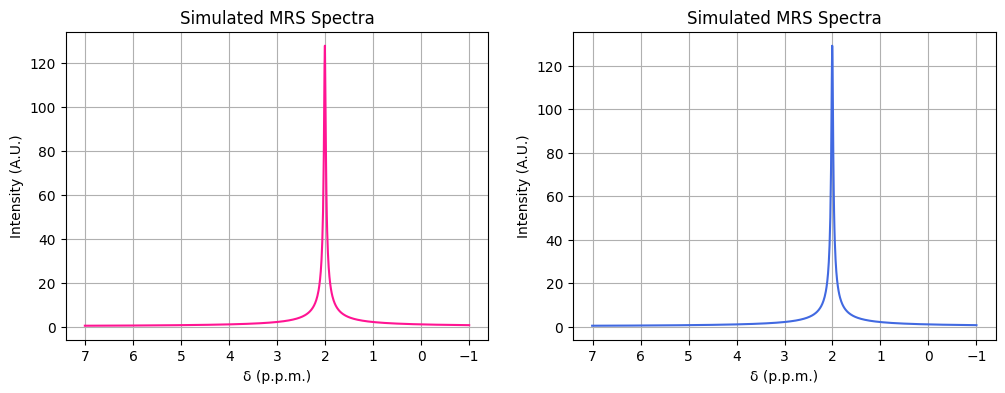

In [61]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)
pop2 = pymri.population(ws2, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

sig2, t = pymri.population_transverse_decay( t0, tn, dt, pop2, np.array([]) )
freqs, sig_fft2 = pymri.fourier_spectrum( sig2, dt, B0 )

plt.figure(figsize=(12,4))
plt.subplot(121)
pymri.plot_chem_shifts(freqs, sig_fft)

plt.subplot(122)
pymri.plot_chem_shifts(freqs, sig_fft2, c = "royalblue")

(-1.2212453270876722e-14+6.350475700855895e-14j)


([], [])

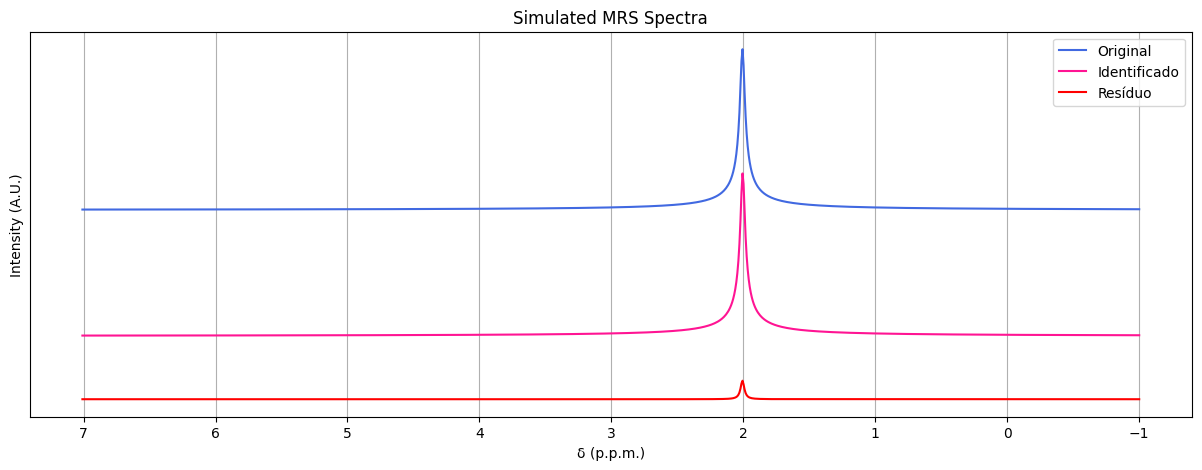

In [62]:
y_offset = 100.0

print(np.sum(sig_fft2 - sig_fft))

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, sig_fft, 1.0, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, sig_fft2, 1.0, y_offset=2*y_offset, label="Identificado")
pymri.plot_chem_shifts(freqs, sig_fft - sig_fft2, 1.0, y_offset=1.5*y_offset, label="Resíduo", c = "red")
plt.legend()
plt.yticks([])

Por mais que o offset seja melhor que a resolução, isso influencia sim no resultado final, visto que por mais que seja percebido como um pico só, a amplitude ainda será menor do que a máxima, que é quando há dois picos posicionados exatamente na mesma frequência, resultando em uma diferença, mesmo que pequena, entre o caso no qual os picos estão completamente sobrepostos e o caso no qual os picos tem uma diferença entre si.